# Vehicle Detection Project

The goal of this project is to write a pipeline to detect vehicles in an image and run the pipeline on a video stream.
For Vehicle detection, we'll use Traditional Computer Vision techniques to map vehicles in a image


## Traditional Computer Vision
Constructing a pipeline to detect images using Traditional computer vision will constitute of the following main parts:
1. Explore the color space to convert images.
2. Apply a color transform and append binned color features (histograms of color) to generate feature vectors on Labeled Training images of Cars and Non-Cars.
3. Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images.
4. Append features generated from 1 and 2 to train a classifier (we'll compare performance of 3 different classifiers viz. Support Vector Machines (Linear SVM), Stochastic Gradient Descent (SGD) and Feed-Forward Deep Neural Networks.
5. Implement a sliding-window technique on our test image and use the trained classifier to search for vehicles in each window.
6. Run the pipeline of a video stream and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
7. Estimate a bounding box for vehicles detected.


## Step 1: Import requried python libraries

In [107]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import glob
from sklearn.model_selection import train_test_split
import time
from sklearn.svm import LinearSVC
#from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import SGDClassifier
#from sklearn.model_selection import GridSearchCV
#from sklearn.pipeline import Pipeline
import pickle
from Evaluate_Model import evaluate_model
import tensorflow as tf
#from itertools import chain
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from PIL import Image
from IPython.display import HTML
from skimage.feature import hog
import random
from mpl_toolkits.mplot3d import Axes3D

from Neural_Network import train_Neuralnet
import logging
%matplotlib inline

### Step 2: First Look at the Data
Labeled data for vehicle and non-vehicle images give to us come from a combination of the GTI vehicle image database, the KITTI vision benchmark suite, and examples extracted from the project video itself.

Let's plot a few Car and Non-Car images to get an idea.

Text(0.5,1,'Not Car 3')

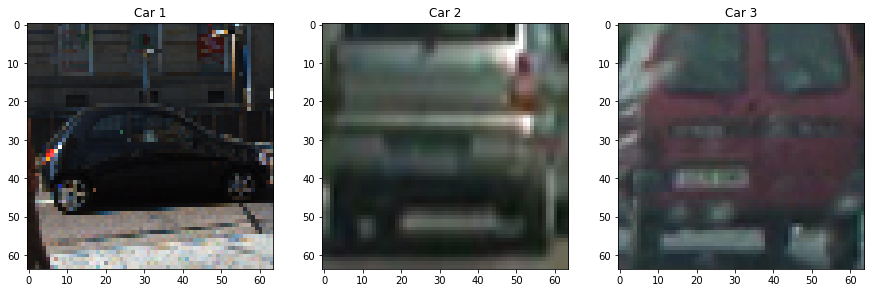

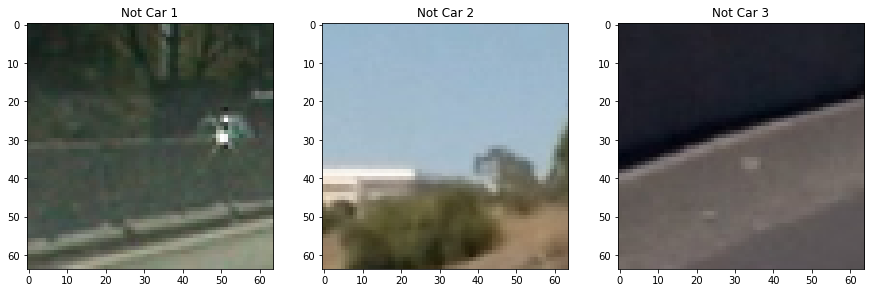

In [109]:
cars_path = glob.glob('vehicles/GTI_Far/*.png') + glob.glob('vehicles/GTI_Left/*.png') + \
           glob.glob('vehicles/GTI_MiddleClose/*.png') + glob.glob('vehicles/GTI_Right/*.png') + \
           glob.glob('vehicles/KITTI_extracted/*.png')

not_cars_path = glob.glob('non-vehicles/Extras/*.png') + glob.glob('non-vehicles/GTI/*.png')

car_images= []
not_car_images = []
for i in range(3):
    ind = np.random.randint(0, len(cars_path))
    car_images.append(mpimg.imread(cars_path[ind]))
    not_car_images.append(mpimg.imread(not_cars_path[ind]))
plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(car_images[0])
plt.title('Car 1')
plt.subplot(132)
plt.imshow(car_images[1])
plt.title('Car 2') 
plt.subplot(133)
plt.imshow(car_images[2])
plt.title('Car 3') 
plt.figure(figsize=(15,15))
plt.subplot(231)
plt.imshow(not_car_images[0])
plt.title('Not Car 1')
plt.subplot(232)
plt.imshow(not_car_images[1])
plt.title('Not Car 2') 
plt.subplot(233)
plt.imshow(not_car_images[2])
plt.title('Not Car 3') 

    
    

## Step 3: Feature Selection
Generate feature vectors for Car and Non Car images to train a classifier.

### Step 3.1: Explore color space
Idea is to study the distribution of color values in an image by plotting each pixel in some color space. This will enable us to observe how pixels of different colors get clustered in different color spaces.

**NOTE: In this project we use mpg.imread() method from matplotlib.image which reads PNG images on a scale of 0 to 1, JPG images on a scale of 0 to 255 and the color space it uses is RGB.**

##### Code comments
1. Let's build a function which accepts image and desired color space as input parameters and returns the converted image (into the desired color space)
2. Test the function for a sample image

We'll use the desired color space to convert the image and generate feature vectors

In [110]:
def convert_color(img, cspace = 'RGB'):
    if cspace != 'RGB':
        if cspace == 'HSV':
            new_color_space = cv2.COLOR_RGB2HSV
        elif cspace == 'HLS':
            new_color_space = cv2.COLOR_RGB2HLS
        elif cspace == 'LUV':
            new_color_space = cv2.COLOR_RGB2LUV
        elif cspace == 'YUV':
            new_color_space = cv2.COLOR_RGB2YUV
        elif cspace == 'HLS':
            new_color_space = cv2.COLOR_RGB2HLS   
        elif cspace == 'RGB2YCrCb':
            new_color_space = cv2.COLOR_RGB2YCrCb
        elif cspace == 'BGR2YCrCb':
            new_color_space = cv2.COLOR_BGR2YCrCb
        elif cspace == 'BGR2LUV':
            new_color_space = cv2.COLOR_BGR2LUV
        img_converted = cv2.cvtColor(img, new_color_space)
    else:
        img_converted = np.copy(img)   
    return img_converted

#### Define a function to create 3D plots of color pixels in different color spaces.

In [111]:
def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=((0, 255), (0, 255), (0, 255))):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(5, 5))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation

#### Plot the image on different color spaces

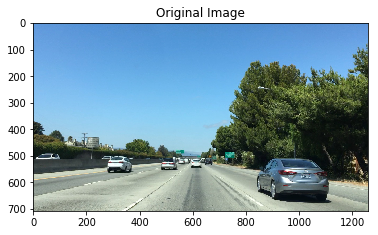

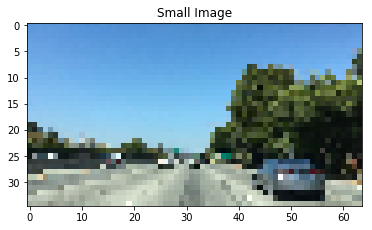

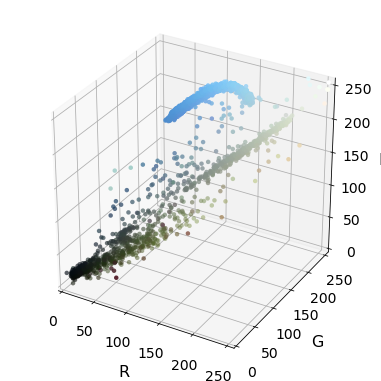

In [112]:

img =  mpimg.imread("bbox-example-image.jpg")
plt.imshow(img)
plt.title('Original Image')
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)
img_small_rgb = img_small / 255

plt.figure(figsize=(6,6))
plt.imshow(img_small)
plt.title('Small Image')
plot3d(img_small, img_small_rgb)
plt.show()

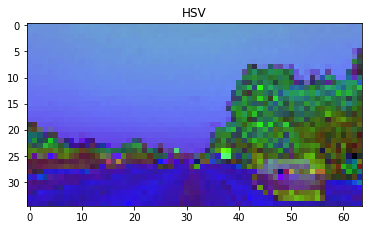

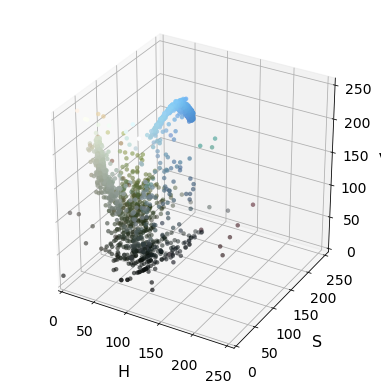

In [113]:
desired_color_space = 'HSV'
plt.figure(figsize=(6,6))
img_converted = convert_color(img_small, desired_color_space)
plt.imshow(img_converted)
plt.title(desired_color_space)
plot3d(img_converted, img_small_rgb, axis_labels=list(desired_color_space))
plt.show()

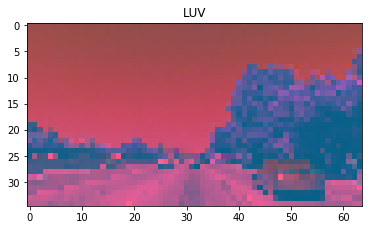

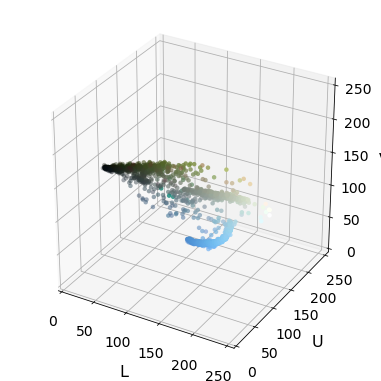

In [114]:
desired_color_space = 'LUV'
plt.figure(figsize=(6,6))
img_converted = convert_color(img_small, desired_color_space)
plt.imshow(img_converted)
plt.title(desired_color_space)
plot3d(img_converted, img_small_rgb, axis_labels=list(desired_color_space))
plt.show()

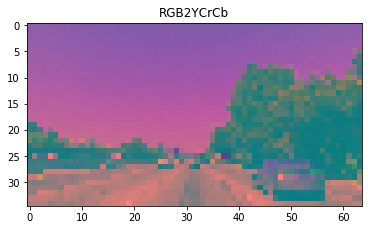

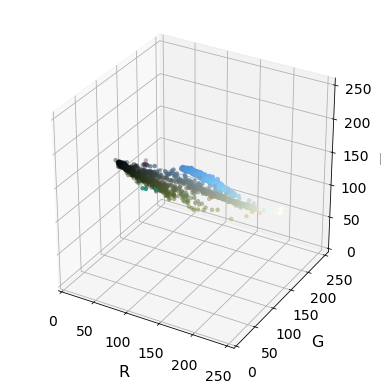

In [115]:
desired_color_space = 'RGB2YCrCb'
plt.figure(figsize=(6,6))
img_converted = convert_color(img_small, desired_color_space)
plt.imshow(img_converted)
plt.title(desired_color_space)
plot3d(img_converted, img_small_rgb, axis_labels=list(desired_color_space))
plt.show()

After exploring different color spaces, it appears that the pixels in LUV color space appear to cluster well for car images. Hence our desired color space for generating features is LUV. 

### Step 3.2: Extract color histogram features
Compute the histogram of color values in an image. This will enable the model to compare the histogram of colors in an known image with the regions of test image. Locations with similar color distributions will identify the close match.
However, the disadvantage of this method is the dependence of the structure of the image is removed. i.e. We are no longer sensitive to perfect arrangement of color pixels. Any new test image with same color distribution and slightly with different aspects and orientations will still be identified as a match.  
Also, we are solely relying on histogram of color values, the test image predictions may not be accurate. Look at the example below. (taken from the lecture videos)  

![](document_images/Histogram_features_failure.jpg)  
    
**Udacity sign board (test image)** is identified as a **Red car (train image)** because the color distributions in the histograms of train and test images are almost identical.  

Training data with only color histogram features may not be fully effective, but when combined with other features (discussed below) will definitely provide some gain to the performance of the model.

##### Code comments
    1. Car images provided are from vehicles data set available in GTI* folder(containing time series images) and KITTI folder
    2. Read an image an convert it to a desired color space.
    3. Use numpy's histogram function to generate histogram of colors for every channel  in desired color space.
    4. np.histogram() returns a tuple of two arrays. In this case, for example, ch0hist[0] contains the counts in each of the   bins and ch0hist[1] contains the bin edges (so it is one element longer than ch0hist[0]).
    5. Concatenate histogram features of all the 3 channels and return it as a feature vector for our use in training set.

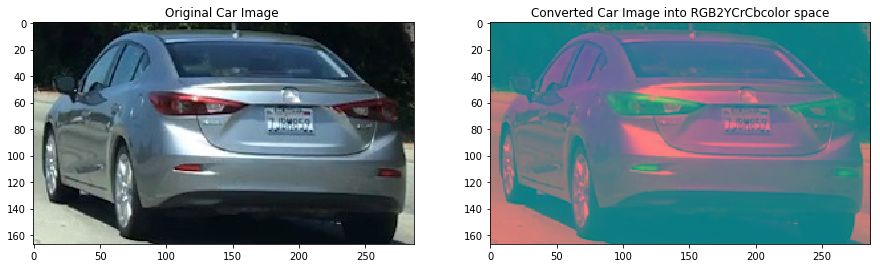

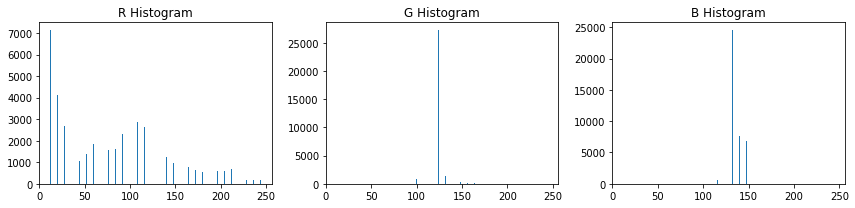

In [116]:
# Read the image
image = mpimg.imread('document_images/cutout6.jpg')
img_converted = convert_color(image, desired_color_space)

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256), plot = False):
    # Compute the histogram of the RGB channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=32, range=(0, 256))
    channel2_hist = np.histogram(img[:,:,1], bins=32, range=(0, 256))
    channel3_hist = np.histogram(img[:,:,2], bins=32, range=(0, 256))
    
    # Generating bin centers
    bin_edges = channel1_hist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    
    if plot:        
        # Plot a figure with all three bar charts
        fig = plt.figure(figsize=(12,3))
        plt.subplot(131)
        plt.bar(bin_centers, channel1_hist[0])
        plt.xlim(0, 256)
        plt.title(desired_color_space[0] +' Histogram')
        plt.subplot(132)
        plt.bar(bin_centers, channel2_hist[0])
        plt.xlim(0, 256)
        plt.title(desired_color_space[1] +' Histogram')
        plt.subplot(133)
        plt.bar(bin_centers, channel3_hist[0])
        plt.xlim(0, 256)
        plt.title(desired_color_space[2] +' Histogram')
        fig.tight_layout()
    
    # Concatenate RGB Histograms
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))    
    return hist_features
    

fig = plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(image)
plt.title('Original Car Image ')
plt.subplot(122)
plt.imshow(img_converted)
plt.title('Converted Car Image into ' + desired_color_space + 'color space')
plt.show()

hist_features = color_hist(img_converted, nbins=32, bins_range=(0, 256), plot = True)


### Step 3.3: Spatial Binning
Using raw pixels of an image can be quite useful if included in feature vectors for training.

Feature vectors will be of a very large size if we use raw pixels from an image with high resolution. Instead, we can perform spatial binning to reduce the resolution of an image and still retain enough information to help finding vehicles. Images with smaller resolution generate smaller feature vectors. 

We chose 32x32 spatial size to allow a decent compression of the image without losing a lot of information.

##### Code Comments:
    1. bin_spatial function accepts an image, converts it a desired color space and performs spatial binning to reduce the size using cv2.resize. Also, it returns the feature vector of the resized image
    2. Plotted images are Original image of size 64x64, Resized image of size 32x32 and plot of feature vectors.


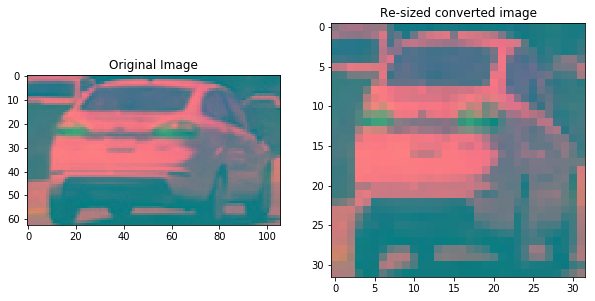

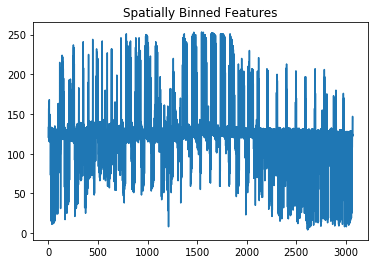

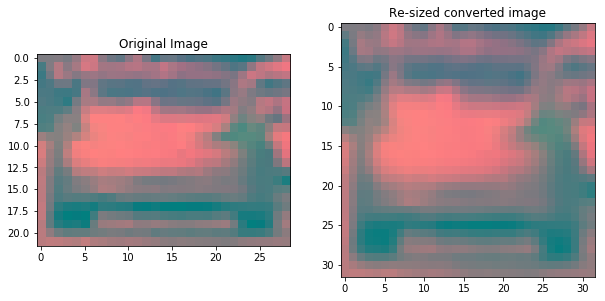

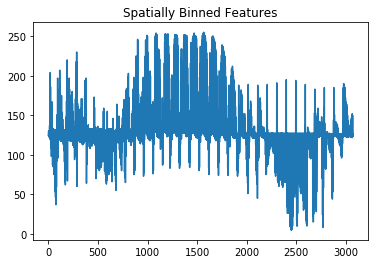

In [117]:
def bin_spatial(img, size=(32, 32), plot = False):
    # Convert image to new color space (if specified)
    # Use cv2.resize().ravel() to create the feature vector
    
    img_small = cv2.resize(img, size)
    features = img_small.ravel() 
    
    
    if plot:
        plt.figure(figsize=(10,10))
        plt.subplot(121)
        plt.imshow(img)
        plt.title('Original Image')
        plt.subplot(122)
        plt.imshow(img_small)
        plt.title('Re-sized converted image')    
        plt.show()

        plt.plot(features)
        plt.title('Spatially Binned Features')
    # Return the feature vector
    return features

image = mpimg.imread('document_images/cutout1.jpg')
img_converted = convert_color(image, desired_color_space)
feature_vec = bin_spatial(img_converted, size=(32, 32), plot = True)

image = mpimg.imread('document_images/cutout3.jpg')
img_converted = convert_color(image, desired_color_space)
spatial_features = bin_spatial(img_converted, size=(32, 32), plot = True)


### Step 3.4: Histogram of Oriented Gradient features
Color values from an image (like histogram of colors and raw pixels of an image) will only capture one aspect of object's appearance. When objects vary in color, it is very important to capture the structural queues **(like shape)** of an object. You can actually estimate the shape of an object using directions of gradients around the center in an image.

In this specific use-case, our training images are of size 64x64 pixels. The first step is to divide the image into 8x8 cells each cell containing 64 pixels. Then we will compute gradients for each of the 64 pixels within each cell. Then the gradients are separated into bins to create a histogram. So stronger gradients add more weight to the orientation bin and stand out as a dominating direction for that cell. Thus, effect of small gradients due to noise is reduced.  

In other words, each pixel in the cell gets to vote on which histogram bin it belongs to based on gradient direction at that position. The strength of the vote depends on the gradient magnitude at that pixel.  

When we do this for all the cells in an image, the representation of the structure in an image will eventually emerge. The main advantage of this technique is we now have the ability to accept small variations in the shape of an object in an image.
But why 8×8 patch ? Why not 32×32 ? It is a design choice informed by the scale of features we are looking for. The histogram is essentially a vector ( or an array ) of 9 bins ( numbers ) corresponding to angles 0, 20, 40, 60 … 160.

The following figure illustrates the process. We are looking at magnitude and direction of the gradient of the same 8×8 patch as in the previous figure. A bin is selected based on the direction, and the vote ( the value that goes into the bin ) is selected based on the magnitude. Let's first focus on the pixel encircled in blue. It has an angle ( direction ) of 80 degrees and magnitude of 2. So it adds 2 to the 5th bin. The gradient at the pixel encircled using red has an angle of 10 degrees and magnitude of 4. Since 10 degrees is half way between 0 and 20, the vote by the pixel splits evenly into the two bins.  

![](document_images/HOG1.jpg)  

There is one more detail to be aware of. If the angle is greater than 160 degrees, it is between 160 and 180, and we know the angle wraps around making 0 and 180 equivalent. So in the example below, the pixel with angle 165 degrees contributes proportionally to the 0 degree bin and the 160 degree bin.  

![](document_images/HOG2.jpg)  

The contributions of all the pixels in the 8×8 cells are added up to create the 9-bin histogram. For the patch above, it looks like this.  

![](document_images/HOG3.jpg)

More details on Histogram of Oriented Gradients can learned from the following website:
[Open CV Histogram of Oriented Gradients ](https://www.learnopencv.com/histogram-of-oriented-gradients/)

##### Code Comments
    1. The scikit-image hog() function takes in a single color channel or gray-scaled image as input, as well as various parameters. These parameters include orientations, pixels_per_cell and cells_per_block.  

    2. The number of orientations is specified as an integer, and represents the number of orientation bins that the gradient information will be split up into in the histogram. Typical values are between 6 and 12 bins.  

    3. The pixels_per_cell parameter specifies the cell size over which each gradient histogram is computed. This parameter is passed as a 2-tuple so you could have different cell sizes in x and y, but cells are commonly chosen to be square.  

    4. The cells_per_block parameter is also passed as a 2-tuple, and specifies the local area over which the histogram counts in a given cell will be normalized. Block normalization is not necessarily required, but generally leads to a more robust feature set.  

    There is another optional power law or "gamma" normalization scheme set by the flag transform_sqrt. This type of normalization may help reduce the effects of shadows or other illumination variation, but will cause an error if your image contains negative values (because it's taking the square root of image values).
![](document_images/HOG4.jpg)

    5. If hog_channel is ALL, extract hog features for each channel individually and combine them.
    6. If vis = True, hog() method returns the image along with Hog features. The image displays the gradients. Can be plotted.  


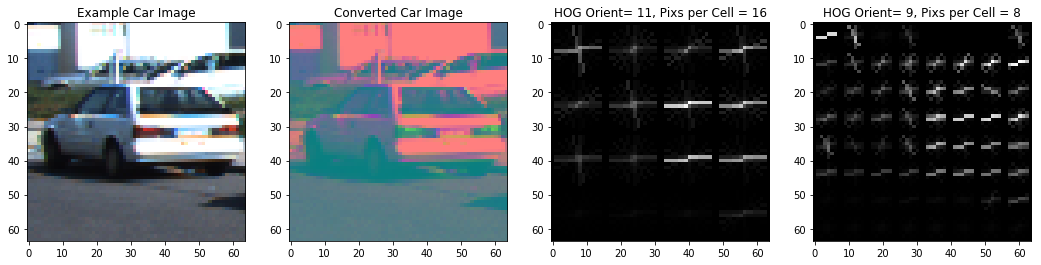

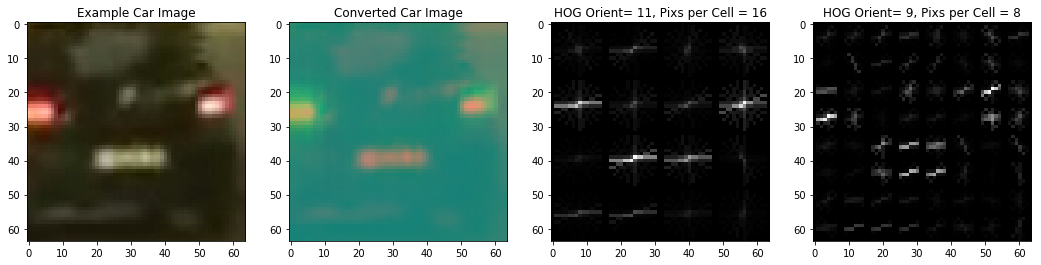

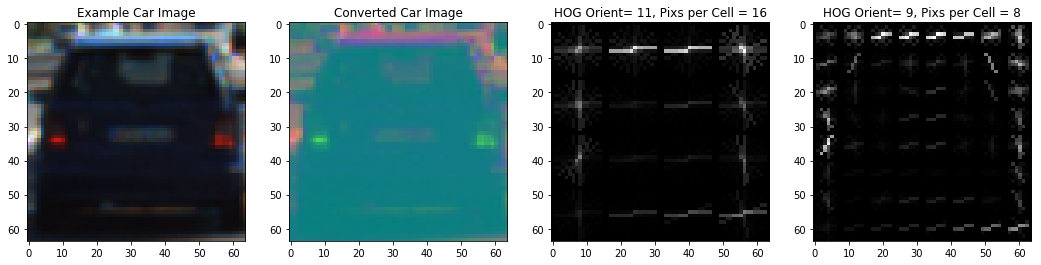

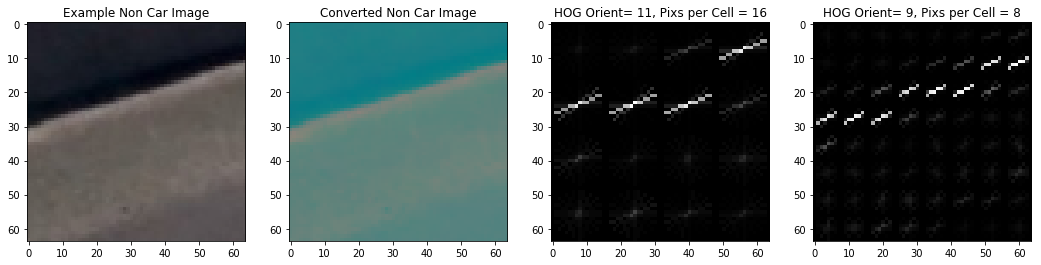

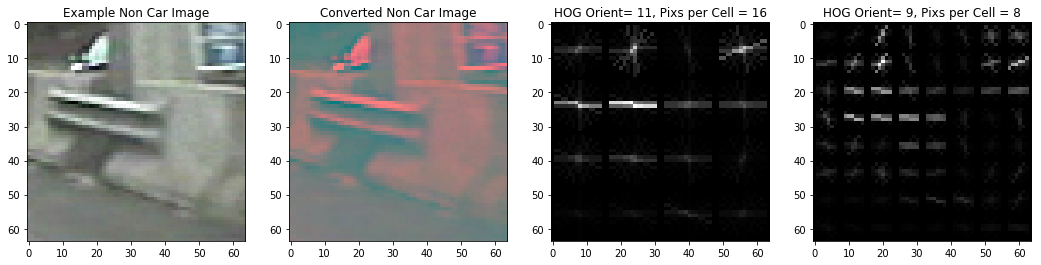

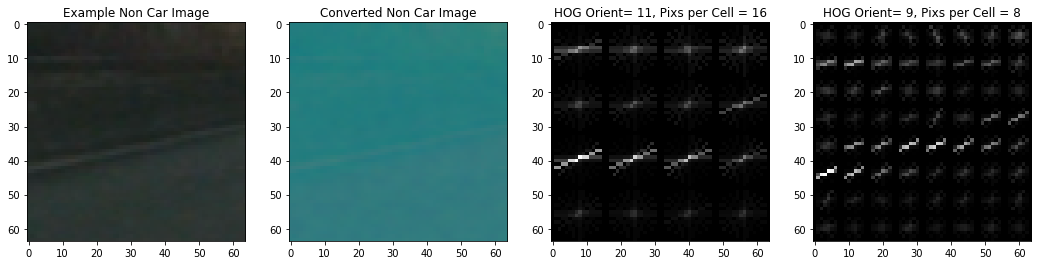

In [119]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis = False, 
                     feature_vec=True, hog_channel =  'ALL'):
                         
    # TODO: Complete the function body and returns
    if hog_channel == 'ALL':
            hog_features = []
            for channel in range(img.shape[2]):               
                hog_features_channel = hog(img[:,:,channel], orientations = orient,
                                           pixels_per_cell = (pix_per_cell, pix_per_cell), 
                                           cells_per_block = (cell_per_block, cell_per_block), 
                                           visualise = vis, feature_vector = feature_vec,
                                           block_norm="L2-Hys",
                                           transform_sqrt=False)
                hog_features.append(hog_features_channel)
            hog_features = np.ravel(hog_features)
    else:
        if vis:        
            hog_features, hog_image = hog(img, orientations = orient,
                                          pixels_per_cell = (pix_per_cell, pix_per_cell), 
                                          cells_per_block = (cell_per_block, cell_per_block), 
                                          visualise = vis, feature_vector = feature_vec,
                                          block_norm="L2-Hys",
                                          transform_sqrt=False)
            
            return hog_features, hog_image
                
            
        else:
            hog_features = hog(img, orientations = orient,
                                          pixels_per_cell = (pix_per_cell, pix_per_cell), 
                                          cells_per_block = (cell_per_block, cell_per_block), 
                                          visualise = vis, feature_vector = feature_vec,
                                          block_norm="L2-Hys",
                                          transform_sqrt=False)
                
    return hog_features  


# Generate a random index to look at a car image
for i in range(3):
    ind = np.random.randint(0, len(cars_path))
    # Read in the image
    image = mpimg.imread(cars_path[ind])
    image_converted = convert_color(image, desired_color_space)
    single_channel = image_converted[:,:,0] #cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Call our function with vis=True to see an image output
    features, hog_image1 = get_hog_features(single_channel, orient = 11, 
                                           pix_per_cell = 16, cell_per_block = 2, 
                                           vis = True, feature_vec = True,
                                           hog_channel =  i
                                          )
    features, hog_image2 = get_hog_features(single_channel, orient = 9, 
                                           pix_per_cell = 8, cell_per_block = 2, 
                                           vis = True, feature_vec = True,
                                           hog_channel =  i
                                          )
  
    # Plot the examples
    fig = plt.figure(figsize=(18,18))
    plt.subplot(141)
    plt.imshow(image)
    plt.title('Example Car Image')
    plt.subplot(142)
    plt.imshow(image_converted)
    plt.title('Converted Car Image')
    plt.subplot(143)
    plt.imshow(hog_image1, cmap='gray')
    plt.title('HOG Orient= 11, Pixs per Cell = 16')  
    plt.subplot(144)
    plt.imshow(hog_image2, cmap='gray')
    plt.title('HOG Orient= 9, Pixs per Cell = 8')
    
for i in range(3):
    ind = np.random.randint(0, len(not_cars_path))
    # Read in the image
    image = mpimg.imread(not_cars_path[ind])
    image_converted = convert_color(image, desired_color_space)
    single_channel = image_converted[:,:,0] #cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Call our function with vis=True to see an image output
    features, hog_image1 = get_hog_features(single_channel, orient = 11, 
                                           pix_per_cell = 16, cell_per_block = 2, 
                                           vis = True, feature_vec = True,
                                           hog_channel =  i
                                          )
    features, hog_image2 = get_hog_features(single_channel, orient = 9, 
                                           pix_per_cell = 8, cell_per_block = 2, 
                                           vis = True, feature_vec = True,
                                           hog_channel =  i
                                          )
  
    # Plot the examples
    fig = plt.figure(figsize=(18,18))
    plt.subplot(141)
    plt.imshow(image)
    plt.title('Example Non Car Image')
    plt.subplot(142)
    plt.imshow(image_converted)
    plt.title('Converted Non Car Image')
    plt.subplot(143)
    plt.imshow(hog_image1, cmap='gray')
    plt.title('HOG Orient= 11, Pixs per Cell = 16')  
    plt.subplot(144)
    plt.imshow(hog_image2, cmap='gray')
    plt.title('HOG Orient= 9, Pixs per Cell = 8')

Tried the following combinations of HOG parameters
    1. Orientations  = 9, Pixels per cell = 8
    2. Orientations  = 11, Pixels per cell = 16
Variation of gradients between both the choices are very subtle. However, option 1 highlights gradients at a higher level detail and are variant enough.

Hence, we chose Orientations  = 11, Pixels per cell = 16
    
    

## Step 4: Building Training Pipeline

At this time, we now have all the functions ready to generate the following feature vectors for any 64 x 64 sized image:
    1. Histogram features
    2. Image features after Spatial binning
    3. Histogram of oriented gradients features

Let's now create a training pipeline using the following steps:

### Step 4.1: Read training images and extract features
1. Define a function __extract_train_features__ which will read all our training images.
Here are links to the labeled data for [vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [non-vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip) examples to train our classifier. These example images come from a combination of the [GTI vehicle image database](http://www.gti.ssr.upm.es/data/Vehicle_database.html), the [KITTI vision benchmark suite](http://www.cvlibs.net/datasets/kitti/), and examples extracted from the project video itself.
2. In Addition to vehicle and non-vehicle images from GTI and KITTI database, we will also use [annotated images](https://github.com/udacity/self-driving-car/tree/master/annotations) Udacity recently released as labeled dataset. This will give us an advantage to augment our training data with lot more labeled examples. *extract_annotated_features* child function is used to read Udacity's annotated features.
3. Most part of a test image will contain portions which is not a car causing model to see them more often. So we feed in more images of non-car during training using augmentation.  
        a. Adjust the brightness of every non-car by a random amount and add it back to the training set.
        b. Select a random few non car images, flip them and add to the training set.
4. Define a child function *extract_features* which will make use of all the functions created *(as part of steps 2.2, 2.3 and 2.4)* to create feature vectors for every image in our data set.
5. Construct labels for images.
6. Return Features as X and labels as y.
7. Save Features and Labels to disk to later use.

In [120]:
def extract_train_features(annotated_features = False):
    
    def extract_annotated_features():
        annotated_cars = []
        annotated_not_cars = []
        path = 'Udacity Dataset/self-driving-car-master/annotations/object-detection-crowdai.tar/'
        read_coords = pd.read_csv(path + 'labels_crowdai.csv')
        for index, row in read_coords.iterrows():
            image = mpimg.imread(path + row['Frame'])
            try:
                image = cv2.resize(image[ row['ymin']:row['ymax'], row['xmin']:row['xmax'], ], (64,64))
                #Our training was done on PNG images and mpgimg.imread function reads PNG images on a scale of 0 to 1
                #Our testing images are JPG images and mpgimg.imread function reads JPG images on a scale of 0 to 255
                #Hence Scale images to convert the range between 0 and 1 
                image = image.astype(np.float32)/255
                if row['Label'] == 'Car':
                    annotated_cars.append(image)
                else:
                    annotated_not_cars.append(image)
            except:
                print('Exception at index' +str(index))
        return annotated_cars, annotated_not_cars
    
    
    def extract_features(imgs,
                     spatial_feat  = True, 
                     hist_feat = True, 
                     hog_feat = True, 
                     hog_channel = 'ALL',
                     cspace = color_space):
        # Create a list to append feature vectors to
        features = []        
        # Iterate through the list of images
            # Read in each one by one
            # apply color conversion if other than 'RGB'
            # Apply bin_spatial() to get spatial color features
            # Apply color_hist() to get color histogram features
            # Append the new feature vector to the features list
        # Return list of feature vectors
        spatial_features = []
        color_hist_features = []
        hog_features = []
        for img in imgs:             
            img_converted = convert_color(img, cspace = color_space)
            if spatial_feat:
                spatial_features = bin_spatial(img_converted, spatial_size)
                
            if hist_feat:
                color_hist_features = color_hist(img_converted, nbins = hist_bins, bins_range=hist_bins_range)        
                
            if hog_feat:
                hog_features = get_hog_features(img_converted, orient, pix_per_cell, cell_per_block, vis = False, 
                                                feature_vec=True, hog_channel =  'ALL') 
                            
            features.append(np.concatenate([spatial_features, color_hist_features, hog_features]))  
        return features
    
    
    print('Reading Image Paths')
    cars = glob.glob('vehicles/GTI_Far/*.png') + glob.glob('vehicles/GTI_Left/*.png') + \
           glob.glob('vehicles/GTI_MiddleClose/*.png') + glob.glob('vehicles/GTI_Right/*.png') + \
           glob.glob('vehicles/KITTI_extracted/*.png')

    not_cars = glob.glob('non-vehicles/Extras/*.png') + glob.glob('non-vehicles/GTI/*.png')
    
   
    # Get Train features and labels
    print('Extracting Features from images')   
    
    car_images= []
    not_car_images= []
    for img_path in cars:
        image = mpimg.imread(img_path)
        car_images.append(image)
    for img_path in not_cars:
        image = mpimg.imread(img_path)
        not_car_images.append(image)
        
    # Augment Not Car Images        
    print('Augmenting Not Car Images')
    augmented_images = []
    for idx, img in enumerate(not_car_images):            
            ##Randomly Adjust Brightness of images 
            new_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            brightness_level = (0.2 * np.random.uniform()) + 0.4
            new_img[:,:,2] = new_img[:,:,2] * brightness_level
            new_img = cv2.cvtColor(new_img, cv2.COLOR_HSV2RGB)
            
            # Randomly shift the image virtially and horizontally           
            x_shift = 100 * (np.random.rand() - 0.6)
            y_shift = 20 * (np.random.rand() - 0.4)
            transition_matrix = np.float32([[1, 0, x_shift],[0, 1, y_shift]])
            height, width = new_img.shape[:2]
            new_img = cv2.warpAffine(new_img, transition_matrix, (width, height))
            
            augmented_images.append(new_img)
            
                        
    #Randomly select images and Flip them and append to main Set
    num_imgs = len(augmented_images)
    random_flip_idx = random.sample(range(num_imgs), num_imgs//2)   
    for idx in random_flip_idx:
         new_img = np.fliplr(augmented_images[idx]) 
         augmented_images.append(new_img)              
    
    not_car_images =  np.vstack((augmented_images, not_car_images))           
    
    if annotated_features:
        annotated_cars, annotated_not_cars = extract_annotated_features()
        print('Length of Annotated Car Images:' +str(len(annotated_cars)))
        print('Length of Annotated Non Car Images:' +str(len(annotated_not_cars)))
    
        car_images =  np.vstack((annotated_cars, car_images))
        not_car_images =  np.vstack((annotated_not_cars, not_car_images))  
    
    
    print('Total Number of Car Images: ' +str(len(car_images)))
    print('Total Number of Non Car Images: ' +str(len(not_car_images)))
    
    
    train_car_features =  extract_features(car_images, spatial_feat  = spatial_feat, 
                                           hist_feat = hist_feat, 
                                           hog_feat = hog_feat, 
                                           hog_channel = hog_channel,
                                           cspace = color_space)

    train_not_car_features =  extract_features(not_car_images, spatial_feat  = spatial_feat, 
                                               hist_feat = hist_feat, 
                                               hog_feat = hog_feat, 
                                               hog_channel = 'ALL',
                                               cspace = color_space) 
    # Create an array stack of feature vectors
    X = np.vstack((train_car_features, train_not_car_features)).astype(np.float64)            
    # Define the labels vector
    y = np.hstack((np.ones(len(train_car_features)), np.zeros(len(train_not_car_features))))  
    
    #Shuffle the data set well enough
    for i in range(5):
        X, y = shuffle(X,y)
    
    return X, y

### Step 4.2: Build train function

1. Build model_train function which accepts features vectors (X) and labels (y) as inputs.
2. Split the features into train and test data. This can be done using _train_test_split_ function provided in scikit-learn's model_selection class. _train_test_split()_ performs both the shuffle and split of the data.
3. Normalize features:  
        a. This is a very important step whenever we train a classifier using numerical features.
        b. Before using our features to train a classifier, we will need to normalize our data. Python's sklearn package provides us with the StandardScaler() method to accomplish this task.  It's important to do the scaling after splitting the data, otherwise you are allowing the scaler to peek into your test data.
        c. Compute the mean and std on train data set using StandardScaler().fit method.
        d. Save the StandardScaler() object used to normalize the train features.This object will later be used to normalize images on unseen test data.
        e. Perform standardization on Train and Test set created in step a (by centering and scaling) using X_scaler.transform() method.
4. Choose a classifier to train. In this project, we have experimented with Linear SVM, Stochastic Gradient Descent (SGD) classifier and Feed forward Artificial neural network.
5. Evaluate the model using _evaluate_model()_ method to test the performance of the classifier on test set (created in step a). Print the confusion matrix and classifier metrics (like Precision, Recall and Accuracy scores).
6. Save the model to disk for later use to retrieve and test on images extracted from project video.
 
#### Neural Network Architecture and Hyperparameters:
    1. 4 fully connected layers.
    2. Layer 1: 1024 Neurons, Relu Activation function and Drop out probability of 0.7.
    3. Layer 2: 512 Neurons, Relu Activation function and Drop out probability of 0.7.
    4. Layer 3: 256 Neurons, Relu Activation function and Drop out probability of 0.7.
    5. Output Layer: 2 Neurons, Softmax Activation function with 2 vector probabilities for Car and Not-Car.
    6. Batch size = 256, Epochs = 15 , Learning rate = 0.001.
    7. Optimizer: Adam.

In [121]:
def model_train(X, y):    
    
    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    print('Splitting Features into Train and test Setsl')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = rand_state)
        
      
    # Fit a per-column scaler only on the training data
    # Save Sclaer to disk
    with open(save_model_path + 'scale_features_X.pkl', 'wb') as output:
        X_scaler = StandardScaler().fit(X_train)
        pickle.dump(X_scaler, output, pickle.HIGHEST_PROTOCOL)
            
   
    
    print('Train, Test Shapes: ', X_train.shape, X_test.shape)
    
    # Train The Model
    print('Training the Model')
    
    if model_name =='SVM':
        # Apply the scaler to X_train and X_test
        X_train = X_scaler.transform(X_train)
        X_test = X_scaler.transform(X_test)
        
        t = time.time()
        clf = LinearSVC(random_state = 1)
        with open(save_model_path + 'Best SVC_Classifier' + '.pkl', 'wb') as output:  
                clf.fit(X_train, y_train)
                print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))
                pickle.dump(clf, output, pickle.HIGHEST_PROTOCOL) 
        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to train SVC...')
        
        
        
        #y_pred_proba = clf.predict_proba(X_test[:, 1])
        y_pred_proba = None
        y_pred = clf.predict(X_test)     
        
        evaluate_model(y_pred, y_test, 'SVM Classifier',  pred_proba = y_pred_proba, ROC_Curve  = False)  
        
    elif model_name == 'SGD':
        X_train = X_scaler.transform(X_train)
        X_test = X_scaler.transform(X_test)
        t = time.time()
        clf = SGDClassifier(random_state = 1, loss = 'log', penalty ='elasticnet', alpha = 0.001, max_iter = 500)
        
        with open(save_model_path + 'SGD_Classifier' + '.pkl', 'wb') as output:  
                clf.fit(X_train, y_train)
                print('Test Accuracy of SGD = ', round(clf.score(X_test, y_test), 4))
                pickle.dump(clf, output, pickle.HIGHEST_PROTOCOL) 
        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to train SGD...')
        y_pred_proba = clf.predict_proba(X_test)[:, 1]
        y_pred = clf.predict(X_test)     
        
        evaluate_model(y_pred, y_test, 'SGD Classifier',  pred_proba = y_pred_proba, ROC_Curve  = True) 
        
    elif model_name == 'Neural_Network':
        t = time.time()
        X_train = X_scaler.transform(X_train)
        train_Neuralnet(X_train, X_test, y_train, y_test, X_scaler,
                        batch_size = 256, epochs = 15 , lr = 0.001, dropout_prob = 0.7) 
        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to train Neural Network...')

### Step 4.3: Define Train Parameters
Final step before training our model is to define the parameters which control how our feature vectors are Generated.
   1. **spatial_size:** Image size for spatial binning.
   2. **hist_bins and hist_bins_range:** Specify the number of bins or the range for Histograms of color features.
   3. **orient:** The number of orientations is specified as an integer, and represents the number of orientation bins that the gradient information will be split up into in the histogram. Typical values are between 6 and 12 bins.
   4. **pix_per_cell:** The pixels_per_cell parameter specifies the cell size over which each gradient histogram is computed. This parameter is passed as a 2-tuple so you could have different cell sizes in x and y, but cells are commonly chosen to be square.
   5. **cell_per_block:** The cells_per_block parameter is also passed as a 2-tuple, and specifies the local area over which the histogram counts in a given cell will be normalized. Block normalization is not necessarily required, but generally leads to a more robust feature set.
   6. **color_space:** The color space of all the images we want to convert to before generating feature vectors. Idea is to study the distribution of color values in an image by plotting each pixel in some color space. This will enable us to observe how pixels of different colors get clustered in different color spaces.
   7. **spatial_feat:** If True, generate Spatial binning features for an image.
   8. **hist_feat:** If True, generate Histogram color features for an image.
   9. **hog_feat:** If True, generate HOG features for an image.
   10. **hog_channel:** If All, use all channels in the image to generate features.
   11. **annotated_features:** If True, use annotated features from Udacity data set.
   12. **model_name:** Specify the classifier to train (In this project we use SVM, SGD and Neural_Network).
   13. **model_train_YN:** If True, train the model. Set it to false if you don't want to train the model.
   14. **train_feature_extract:** If True, generate feature vectors using _extract_train_features()_ method. Set to False, if you want to train another classifier but you have already generated feature vectors using parameters 1 to 9. Setting to False will load the features from disk saving time.
    **NOTE:** : If you change any parameter settings in 1 to 9, set train_feature_extract to True before re-training the classifier.
   15. **save_model_path:**: Path to save trained classifiers (SVM and SGD).
   16. **tf_save_model_path:**: Path to save Neural network weights.


After several experimentations , the values chosen below yielded the best results when used to generate feature vectors.

In [131]:
save_model_path = './model_save/'
tf_save_model_path = './model_save/tf_model'

# Set Image Paramters to Tune while building Features
spatial_size = (32, 32)
hist_bins = 32
hist_bins_range = (0,256)
orient = 11
pix_per_cell = 16
cell_per_block = 2
color_space = 'LUV'
spatial_feat = True
hist_feat = True
hog_feat = True
hog_channel = 'ALL'

annotated_features = False
model_name = 'Neural_Network'
model_train_YN = True
train_feature_extract = True  

### Step 4.4: Train the Model using Neural Network

Reading Image Paths
Extracting Features from images
Augmenting Not Car Images
Total Number of Car Images: 8792
Total Number of Non Car Images: 22420
Features Shape:  (31212, 4356) (31212,)
Splitting Features into Train and test Setsl
Train, Test Shapes:  (21848, 4356) (9364, 4356)
Training the Model
Splitting Features into Train and test Setsl
One-Hot Encode Target
One-Hot Encode Target Complete
Train, Val and Test Shapes:  (21848, 4356) (4682, 4356) (4682, 4356)
Train Labels , Validation Labels and Test Labels Shapes:  (21848, 2) (4682, 2) (4682, 2)
Features Tensor Shape
[None, 4356]
Training 3 layer Feed forward Neural Network classifier
Epoch: 0    - Cost: 0.27     Training Accuracy: 0.953 Validation Accuracy: 0.981
Epoch: 1    - Cost: 0.56     Training Accuracy: 0.977 Validation Accuracy: 0.981
Epoch: 2    - Cost: 0.0717   Training Accuracy: 0.98  Validation Accuracy: 0.984
Epoch: 3    - Cost: 0.0128   Training Accuracy: 0.984 Validation Accuracy: 0.986
Epoch: 4    - Cost: 0.14    

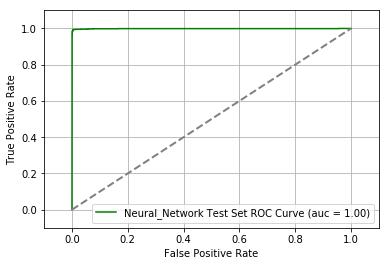

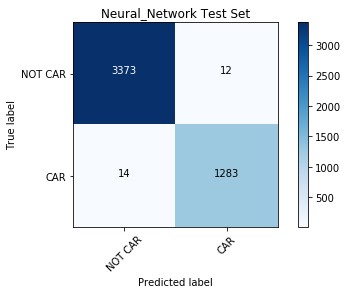

Neural_Network Test Set Accuracy: 0.994447
Neural_Network Test Set Precision: 0.995867
Neural_Network Test Set Recall: 0.996455
Neural_Network Test Set Sensitivity: 0.996455
Neural_Network Test Set Specificity: 0.989206
105.5 Seconds to train Neural Network...


In [132]:
if model_train_YN:    
    if train_feature_extract:    
        X, y = extract_train_features(annotated_features)
        np.save(save_model_path + 'features_X.npy', X)       
        np.save(save_model_path + 'labels_y.npy', y)   
    else:
        print('Reading features from disk')
        X = np.load(save_model_path + 'features_X.npy')
        y = np.load(save_model_path + 'labels_y.npy')
    print('Features Shape: ' , X.shape , y.shape)             
    model_train(X, y) 

### Step 4.5: Train the Model using SVM
Here we set train_feature_extract to False because the features are the same and we don't want to re-generate them.

Reading Image Paths
Extracting Features from images
Augmenting Not Car Images
Total Number of Car Images: 8792
Total Number of Non Car Images: 22420
Features Shape:  (31212, 8460) (31212,)
Splitting Features into Train and test Setsl
Train, Test Shapes:  (21848, 8460) (9364, 8460)
Training the Model
Test Accuracy of SVC =  0.9776
39.08 Seconds to train SVC...


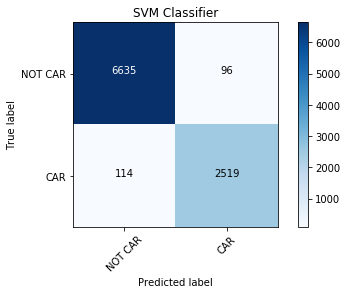

SVM Classifier Accuracy: 0.977574
SVM Classifier Precision: 0.983109
SVM Classifier Recall: 0.985738
SVM Classifier Sensitivity: 0.985738
SVM Classifier Specificity: 0.956703


In [79]:
model_name = 'SVM'
model_train_YN = True
train_feature_extract = False  
if model_train_YN:    
    if train_feature_extract:    
        X, y = extract_train_features()
        np.save(save_model_path + 'features_X.npy', X)       
        np.save(save_model_path + 'labels_y.npy', y)   
    else:
        print('Reading features from disk')
        X = np.load(save_model_path + 'features_X.npy')
        y = np.load(save_model_path + 'labels_y.npy')
    print('Features Shape: ' , X.shape , y.shape)             
    model_train(X, y) 

### Step 4.6: Train the Model using SGD
Here we set train_feature_extract to False because the features are the same and we don't want to re-generate them.

Reading features from disk
Features Shape:  (17760, 4356) (17760,)
Splitting Features into Train and test Setsl
Train, Test Shapes:  (12432, 4356) (5328, 4356)
Training the Model
Test Accuracy of SGD =  0.9878
256.88 Seconds to train SGD...


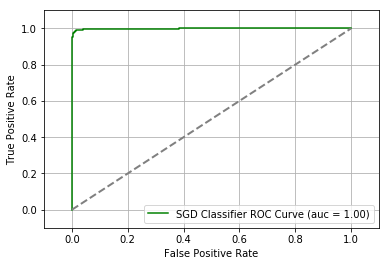

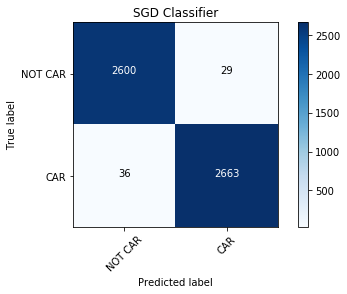

SGD Classifier Accuracy: 0.987800
SGD Classifier Precision: 0.986343
SGD Classifier Recall: 0.988969
SGD Classifier Sensitivity: 0.988969
SGD Classifier Specificity: 0.986662


In [60]:
model_name = 'SGD'
model_train_YN = True
train_feature_extract = False  
if model_train_YN:    
    if train_feature_extract:    
        X, y = extract_train_features()
        np.save(save_model_path + 'features_X.npy', X)       
        np.save(save_model_path + 'labels_y.npy', y)   
    else:
        print('Reading features from disk')
        X = np.load(save_model_path + 'features_X.npy')
        y = np.load(save_model_path + 'labels_y.npy')
    print('Features Shape: ' , X.shape , y.shape)             
    model_train(X, y) 

### Step 4.7: Model Selection
Now, we have all the three models trained and saved to disk. It is very evident that Neural network does an excellent job in classifying cars and not cars with great accuracy. Precision, Recall and Accuracy are above 99%.
**Hence the model of our choice is Neural Network**. However, we'll use all 3 classifiers to test the performance on project video to see how they perform on project video.

## Step 5: Test the Model

### 5.1 Sliding Window Method
In the sliding window method, we need to decide what size window we want to search on the larger test image, where in the image we want to start and stop the search, and how much we want windows to overlap.     
We compute bounding box co-ordinates for each window(grid) of the larger image, extract the smaller image based on the box co-ordinates and feed it to an image classifier to get a prediction (whether an image contains Car, Not-car).

Each window which is also an image. Hence compute the following features for every window and use these features to ping the model and get a prediction (Car vs No Car).
    1. Histogram features
    2. Image features after Spatial binning
    3. Histogram of oriented gradients features
    
If a Car is detected, use bounding box co-ordinates of that window to plot a square at that co-ordinate location on the larger image, indicating a detection.   

**Following text from Lecture Notes**  
We use a more efficient method for doing the sliding window approach, one that allows us to only have to extract the Hog features once, . The code below defines a single function *extract_test_features_boxes* that's able to both extract features and make predictions.

The *extract_test_features_boxes* only has to extract hog features once, for each of a small set of predetermined window sizes (defined by a scale argument), and then can be sub-sampled to get all of its overlaying windows. Each window is defined by a scaling factor that impacts the window size. The scale factor can be set on different regions of the image (e.g. small near the horizon, larger in the center).

For our example are using a 64 x 64 base window. If we define cells per pixel as 8 x 8, then a scale of 1 would retain a window that's 8 x 8 cells (8 cells to cover 64 pixels in either direction). An overlap of each window can be defined in terms of the cell distance, using cells_per_step. This means that a cells_per_step = 2 would result in a search window overlap of 75% (2 is 25% of 8, so we move 25% each time, leaving 75% overlap with the previous window). Any value of scale that is larger or smaller than one will scale the base image accordingly, resulting in corresponding change in the number of cells per window. Its possible to run this same function multiple times for different scale values to generate multiple-scaled search windows.

The following function *extract_test_features_boxes* accepts the following parameters:
    1. img: Larger test image to detect cars in it
    2. scales: The scale factor can be set on different regions of the image (e.g. small near the horizon, larger in the center).
    3. y_start_stop_list: This parameter is a list of tuples. Each tuple has y-start and y-stop co-ordinates. These co-ordinates on the image  specify where to start and stop the search and create windows based on window size. Window size is 64x64 in this scenario.
    
Returns the following:
    1. List of features for all windows of size 64x64.
    2. Bounding box co-ordinates for all windows.

In [124]:
def extract_test_features_boxes(img, scale, y_start_stop):          
    
    #Our training was done on PNG images and mpgimg.imread function reads PNG images on a scale of 0 to 1
    #Our testing images are JPG images and mpgimg.imread function reads JPG images on a scale of 0 to 255
    #Hence Scale images to convert the range between 0 and 1 
    img = img.astype(np.float32)/255
    
    y_start = y_start_stop[0]
    y_stop =  y_start_stop[1]
    
    img_tosearch = img[y_start:y_stop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, cspace = color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    #nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False, hog_channel =  0)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False, hog_channel =  1)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False, hog_channel =  2)
    
                  
    spatial_features = []
    hist_features = []
    hog_features = []
    all_test_features = []
    boxes = []
      
            
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            
            if hog_feat:
            # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                            
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            if spatial_feat:
                spatial_features = bin_spatial(subimg, size = spatial_size)
            if hist_feat:
                hist_features = color_hist(subimg, nbins = hist_bins, bins_range=hist_bins_range)
            #test_features = np.hstack([spatial_features, hist_features, hog_features]).reshape(1, -1) 
            test_features = np.hstack([spatial_features, hist_features, hog_features])
            
            """
            test_features = X_scaler.transform(test_features)
            
            test_prediction = model_predict(test_features, model_name)
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+y_start),(xbox_left+win_draw,ytop_draw+win_draw+y_start),(0,0,255),6) 
            """
            
            all_test_features.append(test_features)            
            
            xbox_left = np.int(xleft * scale)
            ytop_draw = np.int(ytop * scale)
            win_draw = np.int(window * scale)
            box = ((xbox_left, ytop_draw + y_start), (xbox_left + win_draw,ytop_draw + win_draw + y_start))
            boxes.append(box)    
            
    #return draw_img
    return all_test_features, boxes

### 5.2 Build Predict Function
The following function *model_predict* will retrieve the weights (for Neural network) or saved model (for SVM and SGD) from disk and make a prediction (car detected or not in every window).
The parameters passed to the function are:
    1. test_image: The larger test image to detect cars in it.
    2. model_name: Model you want to use to make predictions (SVM, SGD and Neural network)
    3. X_scaler: Scaler object to normalize test features
    4. scales: The scale factor can be set on different regions of the image (e.g. small near the horizon, larger in the center).
    5. y_start_stop_list : This parameter is a list of tuples. Each tuple has y-start and y-stop co-ordinates. These co-ordinates on the image  specify where to start and stop the search and create windows based on window size. Window size is 64x64 in this scenario.
    6. classifier: Scikit learn classifier object if model name is SVM or SGD
    7. sess: Tensor flow session
    8. loaded_x : Tensorflow feature object loaded from disk
    9. loaded_logits: Tensorflow logits loaded from disk
    10: loaded_keep_probability: Drop out probability (1.0)
    
*model_predict* uses the function *extract_test_features_boxes*  to get bounding box co-ordinates for all windows and list of features window features.  

*extract_test_features_boxes()* is called for every **Scale and y_start_stop** combination. This scale factor is set to a smaller value when start and stop co-ordinates are near to the horizon, the scale increases as the search area moves to the center of the image. Each combination of scale and y_start_stop will to create windows from a larger test image. Every window is used to generate features and fed to the test pipeline.

The function returns:
     1. Bounding box co-ordinates where cars are detected.
     2. Larger Image with all the detected cars plotted using bounding boxes.

In [125]:
def  model_predict(test_image, model_name, X_scaler, scales, y_start_stop_list, 
                   classfier = None, sess = None,
                   loaded_x = None, loaded_logits = None, loaded_keep_probability = None):
           
    car_detected_boxes = []
    draw_image = np.copy(test_image)
    for scale, y_start_stop in zip(scales, y_start_stop_list):    
        all_features, boxes = extract_test_features_boxes(test_image, scale, y_start_stop)
        all_features = X_scaler.transform(all_features)
    
        if model_name == 'Neural_Network':
            test_model_feed_dict = {loaded_x: all_features, loaded_keep_probability: 1.0}
            #t2 = time.time()
            #print(round(t2-t, 2), 'Seconds to Retrieve Model')
            softmax_predictions = sess.run(tf.nn.softmax(loaded_logits),feed_dict = test_model_feed_dict)
            test_predictions = []
            for i in range(len(softmax_predictions)):
                if softmax_predictions[i][1] >= 0.5:
                    test_predictions.append(1)
                else:
                    test_predictions.append(0)
            test_predictions = np.array(test_predictions)
        else:
            test_predictions = classfier.predict(all_features)
        for i, pred in enumerate(test_predictions):
            if pred == 1:
                cv2.rectangle(draw_image , boxes[i][0], boxes[i][1], (255,0,0), 6) 
                car_detected_boxes.append(boxes[i])
    return car_detected_boxes, draw_image

### 5.3 Test Pipeline
The following function accepts the larger test image and does the following:
    1. Retrieve the classifier object from disk.
    2. Invoke *model_predict* function to get the list of all bounding boxes where cars are detected and the larger image with boxes plotted
    3. **Remove false positives:** You can see that overlapping detections exist for each of the vehicles in images below. There are also few false positives detected in the portions of an image where's no car. This function will build a heat-map from these detections in order to combine overlapping detections and remove false positives.
    4. "hot" parts of the map are where the cars are. *add_heat* function adds heat where there are multiple overlapping detection. By imposing a threshold, we can reject areas affected by false positives. *apply_threshold* function does that.
    5. Once all the false positives are removed and you have a thresholded heat-map, there are many ways you could go about trying to figure out how many cars you have in each frame and which pixels belong to which cars, but one of the most straightforward solutions is to use the label() function.
    
**Following text taken from lecture notes**  
In the below series of images on the extreme left the same false positive window appeared twice, so if I set a threshold of 2 (meaning set all values <= 2 to 0) and then run the labels() function. I get a result that 2 cars were identified (the two islands in the heat-map) and the labeled image where pixels are set to 0 for background, 1 for car number 1, and 2 for car number 2.

In [126]:
def model_test(test_image):
    
    def add_heat(heatmap, bbox_list):
        # Iterate through list of bboxes
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
        # Return updated heatmap
        return heatmap
    
    def apply_threshold(heatmap, threshold):
        # Zero out pixels below the threshold
        heatmap[heatmap <= threshold] = 0
        # Return thresholded map
        return heatmap
    
    def draw_labeled_bboxes(img, labels):
        # Iterate through all detected cars
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 6)
        # Return the image
        return img 
        
    
    test_image = np.array(test_image)      
    with open(save_model_path + 'scale_features_X.pkl', 'rb') as inputs:
            X_scaler = pickle.load(inputs)          
           
    if model_name == 'SVM':
        with open(save_model_path + 'Best SVC_Classifier' + '.pkl', 'rb') as inputs:
            clf = pickle.load(inputs)
            car_detected_boxes, draw_image = model_predict(test_image, model_name, X_scaler, scales, y_start_stop_list, 
                                                           classfier = clf)
    elif model_name == 'SGD':
        with open(save_model_path + 'SGD_Classifier' + '.pkl', 'rb') as inputs:
            clf = pickle.load(inputs)      
            car_detected_boxes, draw_image = model_predict(test_image, model_name, X_scaler, scales, y_start_stop_list, 
                                                           classfier = clf)
        
    elif model_name == 'Neural_Network':
        loaded_graph = tf.Graph()        
        with tf.Session(graph=loaded_graph) as sess:            
            # Load model
            
            #t = time.time()
            loader = tf.train.import_meta_graph(tf_save_model_path + '.meta')
            loader.restore(sess, tf_save_model_path)

            # Get Tensors from loaded model
            loaded_x = loaded_graph.get_tensor_by_name('x:0')            
            loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
            loaded_keep_probability = loaded_graph.get_tensor_by_name('kp:0') 
            car_detected_boxes, draw_image = model_predict(test_image, model_name, X_scaler, scales, y_start_stop_list, 
                                                           classfier = None, sess = sess,
                                                           loaded_x = loaded_x, loaded_logits = loaded_logits, 
                                                           loaded_keep_probability = loaded_keep_probability)
        
        
    heat  = np.zeros_like(test_image[:,:,0]).astype(np.float)
    heatmap = add_heat(heat, car_detected_boxes)
    heatmap = apply_threshold(heatmap, 2)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    if plot_detections:
        print(labels[1], 'cars found')
    final_image = draw_labeled_bboxes(np.copy(test_image), labels)   
    
    if plot_detections:        
        plt.figure(figsize=(15,15))
        plt.subplot(131)
        plt.imshow(draw_image)
        plt.title('All Detections')
        plt.subplot(132)
        plt.imshow(heatmap, cmap='hot')
        plt.title('All Detections heat')
        plt.subplot(133)
        plt.imshow(final_image)
        plt.title('Final Detection')
    
    
    return final_image          
    

### 5.4 Test Parameters
Most part of the test image contains Blue sky and horizon which adds no value to our model. The best practice is to cut-down the image by trimming co-ordinates on Y axis and retain only the part of the image where we want to start and stop the search.

    1. y_start_stop_list : This parameter is a list of tuples. Each tuple has y-start and y-stop co-ordinates. These co-ordinates on the image  specify where to start and stop the search and create windows based on window size. Window size is 64x64 in this scenario.
    2. scales: The scale factor can be set on different regions of the image (e.g. small near the horizon, larger in the center).
    3. model_name: Choose the classifier you want to use (SVM, SGD and Nueral_Network)
    

In [127]:
# test image parameters
x_start_stop=[None, None]
#y_start_stop_list = [[400,470],[400,550],[420,580], [400,656],[500,580], [410,550], [500,656], [390,585]]
y_start_stop_list = [[400,470], [400,470],[400,550],[420,580], [400,656],[500,656], [410,550], [500,656],[500,656]]
#scales = [1.0, 1.5, 1.5, 1.5, 1.0, 2.0, 2.0, 1.5]
scales = [0.5, 1.0, 1.5, 1.5, 1.5, 1.0, 2.0, 2.0, 1.5]
model_name = 'Neural_Network'
logging.getLogger("tensorflow").setLevel(logging.WARNING)

### 5.5 Make Predictions
Final step: Call **model_test()** function. Pass the test image to detect cars in it.
The return value is the final image with bounding boxes in areas where cars are detected.

Images below show the results on all test images.
    1. Image on the left shows all the positive detections at various scales and search locations.
    2. Image on the center is the heatmap of all positive detections.
    3. Image on the right is constructed bounding boxes to cover the area of each blob detected. First step is to threshold the map to identify vehicle positions. Then use scipy.ndimage.measurements.label() to identify individual blobs in the heatmap. Then assume each blob corresponded to a vehicle. Finally construct bounding boxes to cover the area of each blob detected.

4 cars found
0 cars found
2 cars found
4 cars found
0 cars found
1 cars found
4 cars found
4 cars found
2 cars found
4 cars found


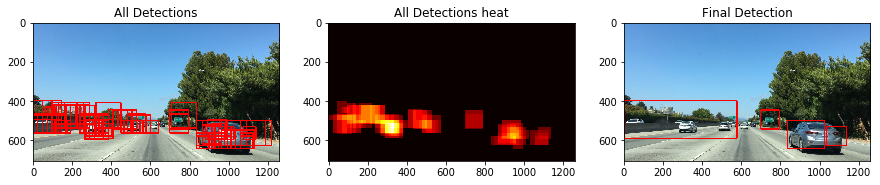

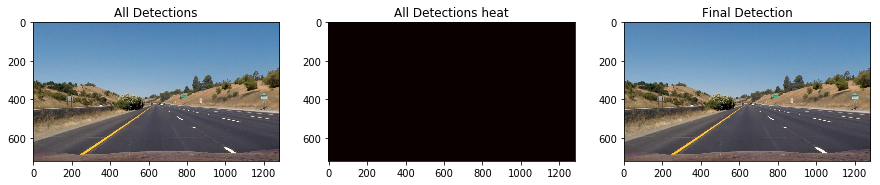

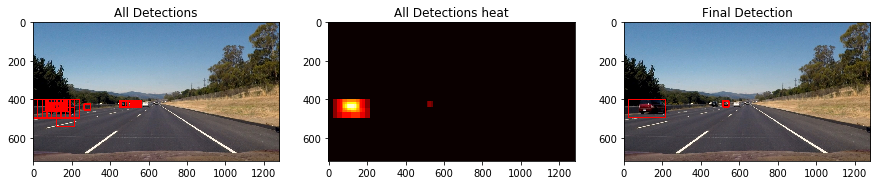

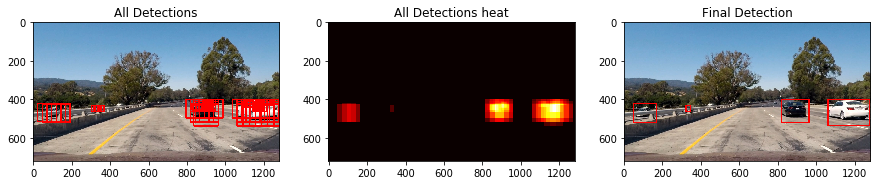

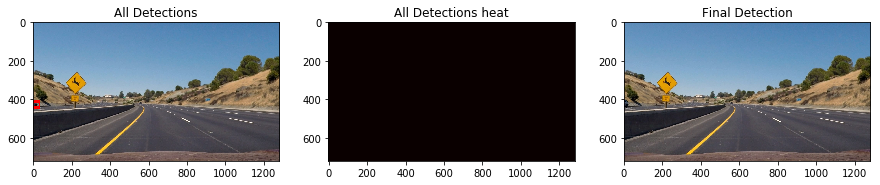

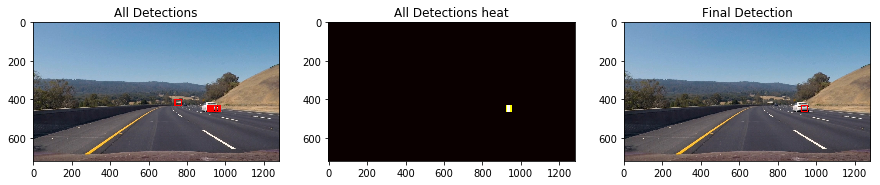

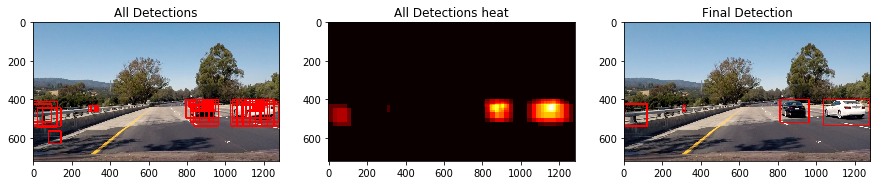

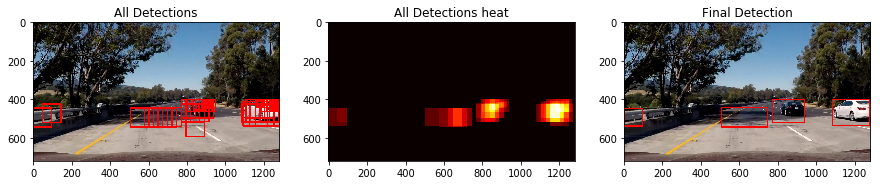

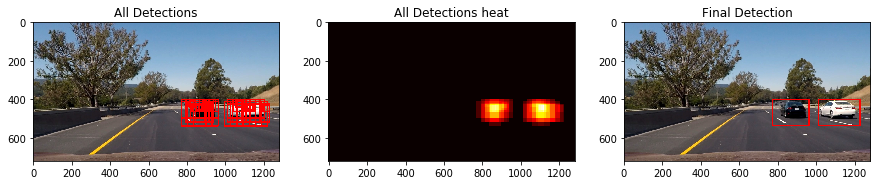

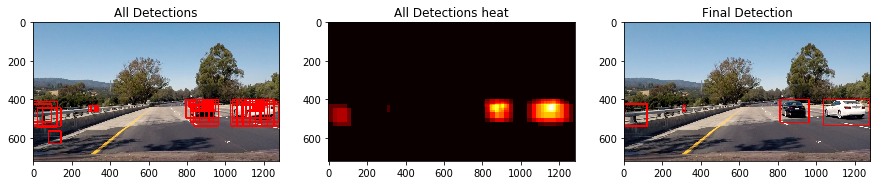

In [128]:
test_images_paths  = glob.glob('test_images/*.jpg') 
plot_detections = True
for path in test_images_paths:
    test_image = mpimg.imread(path)
    final_image = model_test(test_image)

## Step 6: Test on Test Video

In [129]:
plot_detections = False
test_movie_output =  'Videos/test_video_output.mp4'   
clip = VideoFileClip('Videos/test_video.mp4')
image_clip = clip.fl_image(model_test)
%time image_clip.write_videofile(test_movie_output, audio=False)

[MoviePy] >>>> Building video Videos/test_video_output.mp4
[MoviePy] Writing video Videos/test_video_output.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [01:59<00:03,  3.16s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Videos/test_video_output.mp4 

Wall time: 2min


In [130]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_movie_output))

## Step 7: Test on Project Video

In [ ]:
project_video_output =  'Videos/project_video_output.mp4'   
clip3 = VideoFileClip('Videos/project_video.mp4')
image_clip = clip3.fl_image(model_test)
%time image_clip.write_videofile(project_video_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_output))

## Step 8 : Potential gaps and improvement techniques.
The pipeline created above to detect vehicles works well in a constrained set of conditions. The pipeline may fail to detect vehicles in the dark and if the lighting conditions are not appropriate.

Model can be improved by collecting more training examples under variety of lighting conditions. Also, deep neural convlutional neural networks tend to perform better when training data is sufficiently large.


### Deep Neural Network using CNNs.
Deep Neural Network designed for object detection can perform the same tasks mentioned above using a complex interconnected architecture where the stages are not as distinct. Lower layers of a neural network, i.e. the ones closer to the input data, typically perform some equivalent of feature extraction, while higher layers can localize and classify simultaneously to produce detections.
Typically, we follow the steps below to construct the pipeline
1. Build a deep Convolutional Neural Network to feed training images
2. Train the network using a Softmax activation to determine the probability of a car being in an image.
3. Optimize the network using different hyperparameters until Accuracy seems appropriate without overfitting.
4. Implement a sliding-window technique on our test image and use the CNN to predict vehicle's appearance in each window. 
5. Run the pipeline of a video stream and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
6. Estimate a bounding box for vehicles detected.